## Artigo 2 - Flores

### 1. Introdução

Uma rede neural capaz de diferenciar apenas entre duas coisas não é ruim, mas pode ser melhorada. Podemos também torná-la mais acessível, disponibilizando-a através de uma interface gráfica na web disponível para todos os interessados.

Esse é o objetivo da lição 2, e ao final desse artigo, teremos uma rede neural capaz de identificar múltiplas categorias, disponível na web para o público.

### 2. Objetivo

Testar formas novas de redimensionar as imagens do *dataset*, comparar a eficácia de um *dataset* baixado e um gerado por mim, e treinar um modelo capaz de classificar imagens em mais de duas categorias e exportá-lo para ser usado em uma aplicação web.

### 3. Inspiração

Para a lição 2, decidi criar um modelo capaz de classificar imagens em mais do que apenas duas categorias, e o tema escolhido foi flores, inspirado na minha avó, que adora plantas e tem várias espalhadas pela casa inteira.

<p allign="middle">
  <img src="images/jardim.png" width="300" />
  <img src="images/flor.jpg" width="300" /> 
</p>

<em> [1] plantas da vovó </em>

###  4. Execução

In [1]:
import warnings

from fastai.vision.widgets import *
from fastbook import *

# Código para ignorar avisos de usuário
warnings.filterwarnings("ignore", category=UserWarning)

#### 4.1 Adquirir dados

Para começar, vamos pesquisar uma imagem de uma margarida com a função `search_images_ddg`, e depois baixá-la com a função `download_url` para checar se de fato vem uma imagem utilizável da flor.

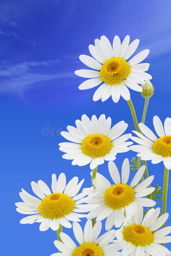

In [44]:
dest = 'margarida.jpg'
download_url(search_images_ddg('margarida flor', max_images=1)[0], dest, show_progress=False) 
Image.open(dest).to_thumb(256,256)

Perfeito. Podemos então criar um laço de repetição que baixa imagens de todas as flores que iremos classificar, sendo elas: 

- Dente de leão
- Margarida
- Rosa
- Tulipa

In [4]:
lista_flores = 'dente-de-leao', 'margarida', 'rosa', 'tulipa'
path = Path('flores')

for tipo in lista_flores:
    dest = (path/tipo)
    dest.mkdir(exist_ok=True, parents=True)
    results = search_images_ddg(f'{tipo} flor')
    download_images(dest, urls=results)

A seguir checamos e removemos qualquer download falho.

In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

#### 4.2 Métodos de redimensionamento

Seguindo a lição 2, vamos treinar o modelo antes de limpar os dados, para utilizar ele em algumas demonstrações.

In [46]:
flores = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256)]
)

In [47]:
dls = flores.dataloaders(path)

A variável `dls` vai guardar os nossos `DataLoaders` de treinamento e validação, e ao ser iterada entrega 64 items que podem ser exibidos através do método `show_batch`:

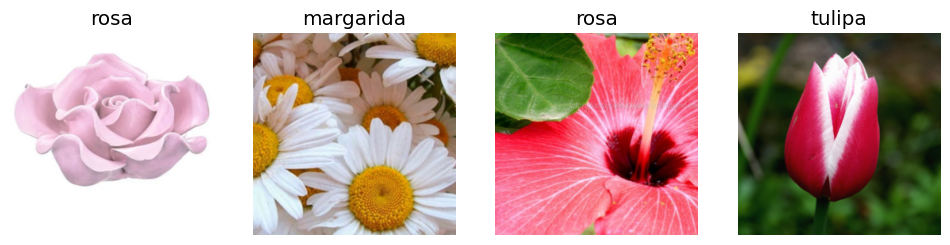

In [48]:
dls.valid.show_batch(max_n=4, nrows=1)

Por padão, o método de redimensionamento do `Resize` é o `crop`, que recorta as bordas da imagem para gerar uma forma quadrada, o que pode remover partes importantes da mesma. Veja a seguir algumas formas alternativas:

O método `squish` achata ou extende a imagem para preservar todos os detalhes, com a consequência de gerar um aspecto distorcido da mesma.

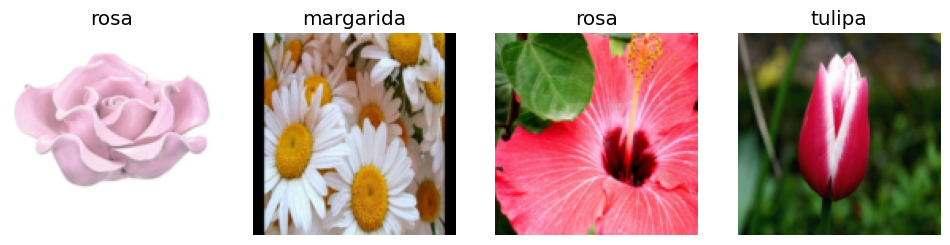

In [49]:
flores = flores.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = flores.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

O método `pad` no modo `zeros` adiciona bordas pretas nas imagens, preservando assim seu aspecto, e sem cortar fora parte alguma.

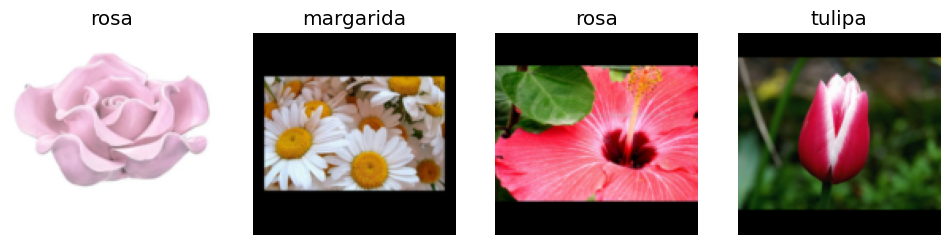

In [50]:
flores = flores.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = flores.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Todos os métodos apresentados possuem problemas, pois o `squish` pode induzir o modelo a aprender com coisas diferentes de como são na verdade, já que os dados recebidos estavam distorcidos; já o `crop` retira partes da imagem que podem ser essenciais para a capacidade do modelo de realizar o reconhecimento; e o `pad` gera muito espaço vazio, que gasta computação e resulta numa resolução efetivamente menor sendo usada.

Alternativamente, podermos selecionar uma parte aleatória da imagem, e cortar apenas ela. Em cada época é selecionada uma parte diferente de cada imagem, o que significa que o modelo pode aprender a focar e reconhecer diferentes características nas imagens.

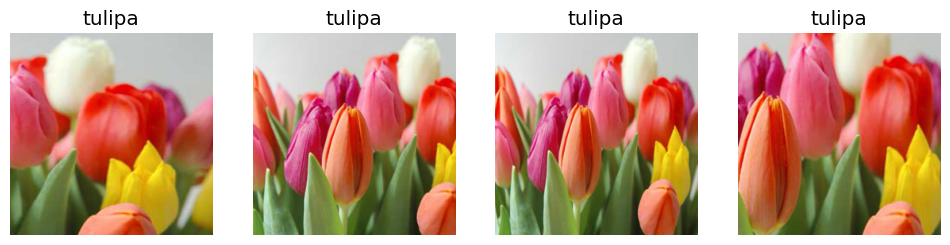

In [51]:
flores = flores.new(item_tfms=RandomResizedCrop(256, min_scale=0.3))
dls = flores.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

O parâmetro `min_scale` determina a porcentagem mínima da imagem para selecionar cada vez, e utilizamos o `unique=True` para fazer a imagem ser repetida com diferentes versões da transformação.

#### 4.3 *Data Augmentation*

*Data augmentation* se trata de criar variações aleatórias dos nossos dados sem alterar o significado deles. Alguns exemplos são rotação, espelhamento, distorção de perspectiva, e mudanças de brilho e contraste. Para isso utilizaremos a função `aug_transforms`, aplicando-a em um lote usando o parâmetro `batch_tfms` para poupar tempo.

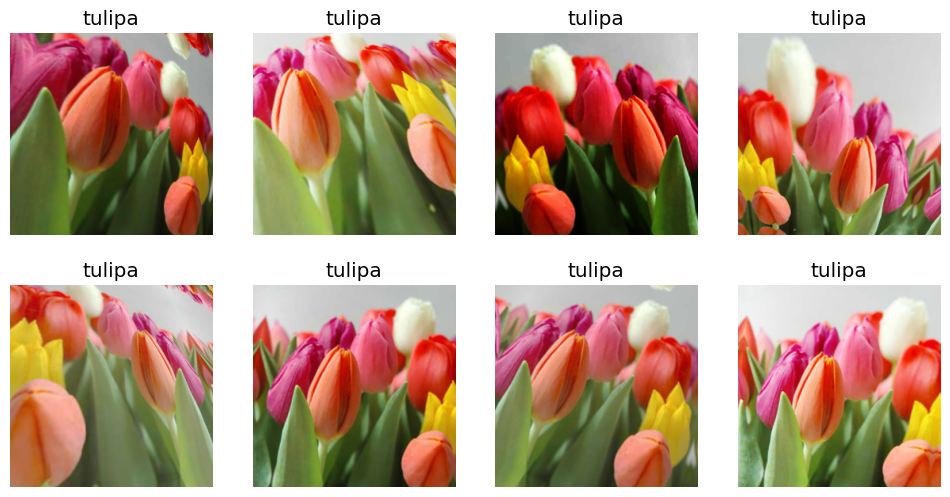

In [52]:
flores = flores.new(item_tfms=Resize(256), batch_tfms=aug_transforms(mult=2))
dls = flores.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

#### 4.4 Treinando o modelo

Para treinar o modelo, vamos combinar o `RandomResizeCrop` com o `aug_transforms` em imagens com tamanho de 224px.

In [76]:
flores = flores.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = flores.dataloaders(path)

Podemos agora criar o `Learner` como de costume.

In [79]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.686800,0.452721,0.143836,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.603694,0.369445,0.130137,00:09
1,0.493807,0.356975,0.130137,00:08
2,0.426900,0.341825,0.109589,00:08
3,0.349342,0.327974,0.095890,00:09


Podemos ver os erros cometidos pelo modelo através da matriz de confusão.

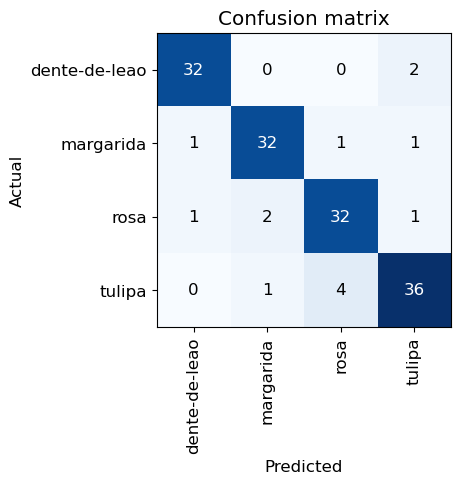

In [80]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

As linhas representam nossas classificações, e as colunas as previsões do modelo. A diagonal principal são os casos de acerto e tudo fora dela são casos que o modelo falhou.

Podemos utilizar o método `plot_top_losses` para ver as imagens que causaram maior erro. 

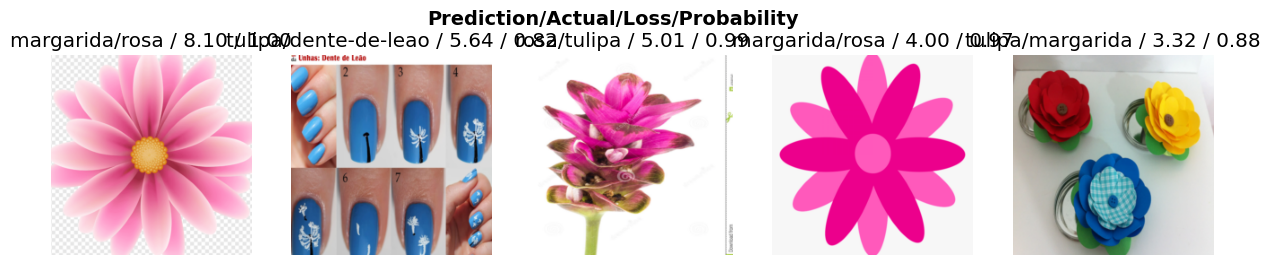

In [81]:
interp.plot_top_losses(5, nrows=1)

Como podemos ver, o maior caso de erro foi em situações que a imagem foi parar na classificação das rosas sem ser de fato uma, devido à sua cor ser rosa.

O intuito de treinar o modelo antes de limpar os dados é utilizar os resultados do modelo para localizar os problemas nos dados.

podemos usar uma interface do fastai chamada `ImageClassifierCleaner` para auxiliar na limpeza dos dados:

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

<img src="images/cleaner.png" width="800" />

Através da interface podemos ver as imagens de flores que não pertencem ao gênero Rosa, mas são da cor rosa, que geraram confusão em nosso modelo. Então podemos selecionar essas imagens e deletá-las pelo seguinte comando:

In [59]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

#### 4.5 Comparação e Exportação

Antes de partir para a exportação do modelo, queria treinar outro com um dataset pronto, onde problemas como o das rosas acima não aconteceria. O que eu escolhi foi o [Flowers Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) por Alexander Mamaev no Keggle.

In [61]:
path2 = Path('flores_pronto')

dls2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(224, min_scale=0.5)],
    batch_tfms=aug_transforms()
).dataloaders(path2)

Para este modelo, vamos utilizar mais épocas pois a quantidade de imagens é muito superior.

In [66]:
learn2 = vision_learner(dls2, resnet18, metrics=error_rate)
learn2.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.946805,0.464265,0.124302,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.404224,0.389696,0.099162,00:16
1,0.328149,0.356982,0.099162,00:15
2,0.263037,0.386158,0.101955,00:16
3,0.201491,0.330916,0.092179,00:15
4,0.140659,0.323173,0.081006,00:15
5,0.112509,0.335830,0.087989,00:16
6,0.085711,0.326862,0.078212,00:16
7,0.073456,0.321403,0.075419,00:16


Como esperado, o modelo feito com o *dataset* pronto apresentou a taxa de erro menor do que o modelo com imagens do duckduckgo,com 7,5% comparado com os 9,5% do seu antecessor.

Vamos então exportar o modelo com menor percentual de erro.

In [82]:
learn2.export('modelo.pkl')

#### 4.6 Aplicação Online

Com o modelo exportado, podemos criar um espaço no [Hugging Face](https://huggingface.co) para publicar uma aplicação web que utiliza nosso modelo para realizar classificações.

Precisamos apenas:
1. Criar um espaço e clonar seu repositório
2. Criar um arquivo `app.py`
3. Adicionar o modelo e algumas imagens de demonstração, além de um arquivo `requirements.txt` com os pacotes necessários (no caso, apenas o fastai)
4. Enviar tudo para o repositório

E então acessar o espaço para ver o modelo em ação.

#### 4.6.1 App.py

--------------
```python
from fastai.vision.all import *
import gradio as gr

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

learn = load_learner('modelo.pkl')
categories = ('Dente de leão', 'Margarida', 'Rosa', 'Tulipa')

image = gr.Image(shape=(192,192))
label = gr.Label()
examples = ['img/d.jpg', 'img/m.jpg', 'img/r.jpg', 'img/t.jpg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)
```
--------------

Aqui podemos carregar nosso modelo através do `load_learner`, adicionar as categorias que desejamos ver no app, e utilizar das ferramentas do gradio para gerar uma interface gráfica para o usuário.

**Obs:** na lição 2, são utilizados os comandos `gr.inputs.Image` e `gr.inputs.Label`, que foram deprecados.

#### 4.6.2 Resultado

Acessando o link do [espaço criado no Hugging Face](https://huggingface.co/spaces/vnsrz/flores), podemos ver a aplicação web rodando, completa com imagens de exemplo.

<p allign="middle">
  <img src="images/hgface.png" width="400" />
  <img src="images/hgface2.png" width="420" /> 
</p>

### 5. Conclusão

Nessa lição, tentei explorar além do que foi passado, indo atrás de um dataset curado para comparar com o meu, e experimentando com o código que foi exposto, expandindo a aplicação web para identificar mais do que duas imagens.

Não estava ciente da plataforma Hugging Face, que proporciona uma aplicação prática e acessível para os modelos treinados no curso do fastai, e estarei frequentando o site mais vezes.

Diferente da última vez, não me deparei com nenhum problema que impedisse meu progresso, e espero que continue assim.